# Entropic Braiding Index
Trying to calculate the eBI and BI ratios from Tejedor et al., 2022

In [219]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy
from shapely.geometry import Polygon, MultiPolygon
import seaborn as sns
from scipy import stats

In [2]:
### Load data
depth = np.load('/Users/safiya/Desktop/depth.npy', allow_pickle = True)
velo = np.load('/Users/safiya/Desktop/velocity.npy', allow_pickle = True)
ylocs = np.load('/Users/safiya/Desktop/ypos.npy', allow_pickle = True)
xlocs = np.load('/Users/safiya/Desktop/xpos.npy', allow_pickle = True)
bedz = np.load('/Users/safiya/Desktop/bed_elevation.npy', allow_pickle = True)
watersurf = np.load('/Users/safiya/Desktop/watersurf.npy', allow_pickle = True)

In [144]:
wsurf = np.expand_dims(watersurf, 0) ## change dimensions to streamwise for watersurf

In [145]:
section_sampling = 25 ## in 10s of m
secstart = 100
secend = 900
adjustment_time = 65
seclist = np.arange(secstart, secend+1, section_sampling)

In [146]:
bed_sample = copy.deepcopy(bedz) ## bed at the section sampled
bed_sample = bedz[:, secstart:secend+1, :]
bed_sample = bed_sample[:, ::25, adjustment_time:]

In [147]:
wsurf_sample = wsurf[:, secstart:secend+1, :]
wsurf_sample = wsurf_sample[:, ::25, adjustment_time:]
print(bed_sample.shape, wsurf_sample.shape)

(705, 33, 317) (1, 33, 317)


In [148]:
ylocs_sample = ylocs[:, secstart:secend+1, :]
ylocs_sample = ylocs_sample[:, ::25, adjustment_time:]
print(ylocs_sample.shape)

(705, 33, 317)


In [149]:
bedz_nan = copy.deepcopy(bed_sample)
ylocs_nan = copy.deepcopy(ylocs_sample)
for t in range(bed_sample.shape[2]):
    for x in range(bed_sample.shape[1]):
        change = np.where(bed_sample[:, x, t]>wsurf_sample[:, x, t])[0]
        bedz_nan[change, x, t] = np.nan
        
ylocs_nan[np.isnan(bedz_nan)] = np.nan

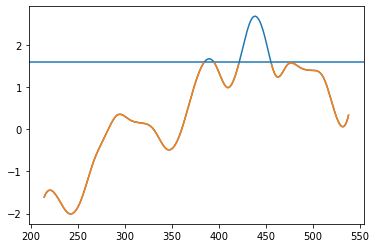

In [82]:
# plt.plot(bedz[:, 100, -1])
plt.plot(bed_sample[:, x, t])
plt.axhline(wsurf_sample[:, x, t])
plt.plot(bedz_nan[:, x, t])

In [203]:
def ebicalc(watermask):
    '''return the ebi of every xs position in an array of [water, not water]
    rows = cross stream position
    columns = x locations
    z = timesteps'''
    
    ebi = np.empty([1, watermask.shape[1], watermask.shape[2]]) ## create a storage matrix for ebi data values
    print(ebi.shape)
    ### current way I can think of doing this is taking each cross section, finding all the thread edges using l_edge, r_edge 
    ### code from polygon diagrams and getting those widths and using width as a Q proxy to get ebi.
    
    for ts in range(watermask.shape[2]):
        for xpos in range(watermask.shape[1]):
            l_idx = np.array([])
            r_idx = np.array([])
            for ypos in range(watermask.shape[0]-1):
                # l_edge = np.logical_and(np.isnan(watermask[ypos, xpos, ts]), ~np.isnan(watermask[ypos, xpos, ts]))
                # r_edge = np.logical_and(~np.isnan(watermask[ypos, xpos, ts]), np.isnan(watermask[ypos:, xpos, ts]))
                
                l_edge = np.all(np.isnan(watermask[ypos, xpos, ts]) and ~np.isnan(watermask[ypos+1, xpos, ts]))
                r_edge = np.all(~np.isnan(watermask[ypos, xpos, ts]) and np.isnan(watermask[ypos+1, xpos, ts]))
                # print(ypos, xpos, ts, l_edge, r_edge) ## yes this works.
                if l_edge == True:
                    l_idx = np.append(l_idx, [ypos], axis = 0)

                if r_edge == True:
                    r_idx = np.append(r_idx, [ypos], axis = 0)
            
            # if len(l_idx) != 0:
                # print(l_idx, r_idx) ## yes this works and pulls the right indices
                
            widths = r_idx-l_idx ## create a list of the thread widths at each position, this will not be output
            
            totwet = np.sum(widths)
            
            ebi[:, xpos, ts] = -1* np.sum((widths/totwet)*np.log2(widths/totwet))
            
    print(ebi.shape)
    return ebi

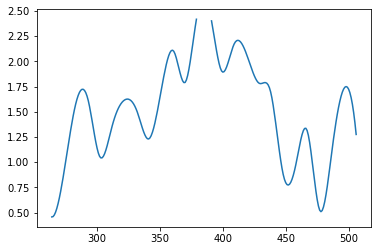

In [158]:
plt.plot(bedz_nan[:, 0, 0])

In [204]:
# ylocs_nan[200:300, 0, 0]
ebi_3d = ebicalc(ylocs_nan)

(1, 33, 317)
(1, 33, 317)


In [205]:
ebi2d = np.transpose(copy.deepcopy(ebi_3d))

In [208]:
ebi2d[:, :, 0]

(317, 33)


In [209]:
ebidf = pd.DataFrame(copy.deepcopy(ebi2d[:, :, 0]), columns = seclist)

In [210]:
ebidf

,100,125,150,175,200,225,250,275,300,325,...,675,700,725,750,775,800,825,850,875,900
0,1.000000,1.389103,-0.0,0.990123,1.675917,0.938575,1.488199,-0.0,1.029190,1.086306,...,0.740731,-0.0,1.640598,-0.000000,0.816984,1.412925,-0.000000,-0.00000,1.746248,1.181787
1,0.999987,1.422324,-0.0,1.364710,1.828197,0.942528,0.992267,-0.0,1.036718,1.089496,...,0.718390,-0.0,1.609263,-0.000000,0.598565,1.255209,0.355251,-0.00000,1.741025,1.806418
2,0.999789,1.241654,-0.0,0.987380,1.884779,0.790369,0.992859,-0.0,1.020721,0.355061,...,0.714727,-0.0,1.532753,0.991553,1.368777,1.282115,-0.000000,-0.00000,0.612614,1.795754
3,0.999988,0.938766,-0.0,-0.000000,1.698905,-0.000000,1.489573,-0.0,0.959420,1.074418,...,1.190368,-0.0,0.988262,-0.000000,0.763674,1.729620,0.299133,-0.00000,1.755994,1.315176
4,0.999987,1.761148,-0.0,-0.000000,1.270989,-0.000000,1.483700,-0.0,0.945420,1.066336,...,1.183812,-0.0,1.809659,-0.000000,0.846525,1.740632,0.300814,-0.00000,0.612614,1.819493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312,-0.000000,-0.000000,-0.0,0.236345,1.467972,-0.000000,1.541702,-0.0,1.518077,-0.000000,...,-0.000000,-0.0,1.564478,-0.000000,-0.000000,-0.000000,0.300218,0.20481,0.770479,1.478477
313,0.650022,-0.000000,-0.0,0.235767,1.666625,-0.000000,1.092026,-0.0,1.518856,-0.000000,...,-0.000000,-0.0,1.553170,-0.000000,-0.000000,-0.000000,-0.000000,-0.00000,1.519693,1.472063
314,1.327173,-0.000000,-0.0,1.128969,1.469108,-0.000000,1.118758,-0.0,1.522567,-0.000000,...,-0.000000,-0.0,1.541002,-0.000000,-0.000000,-0.000000,-0.000000,-0.00000,0.777601,1.481389
315,0.677819,-0.000000,-0.0,0.221188,1.469108,-0.000000,0.990449,-0.0,1.522361,-0.000000,...,-0.000000,-0.0,1.554526,-0.000000,-0.000000,-0.000000,-0.000000,-0.00000,0.777601,1.286121


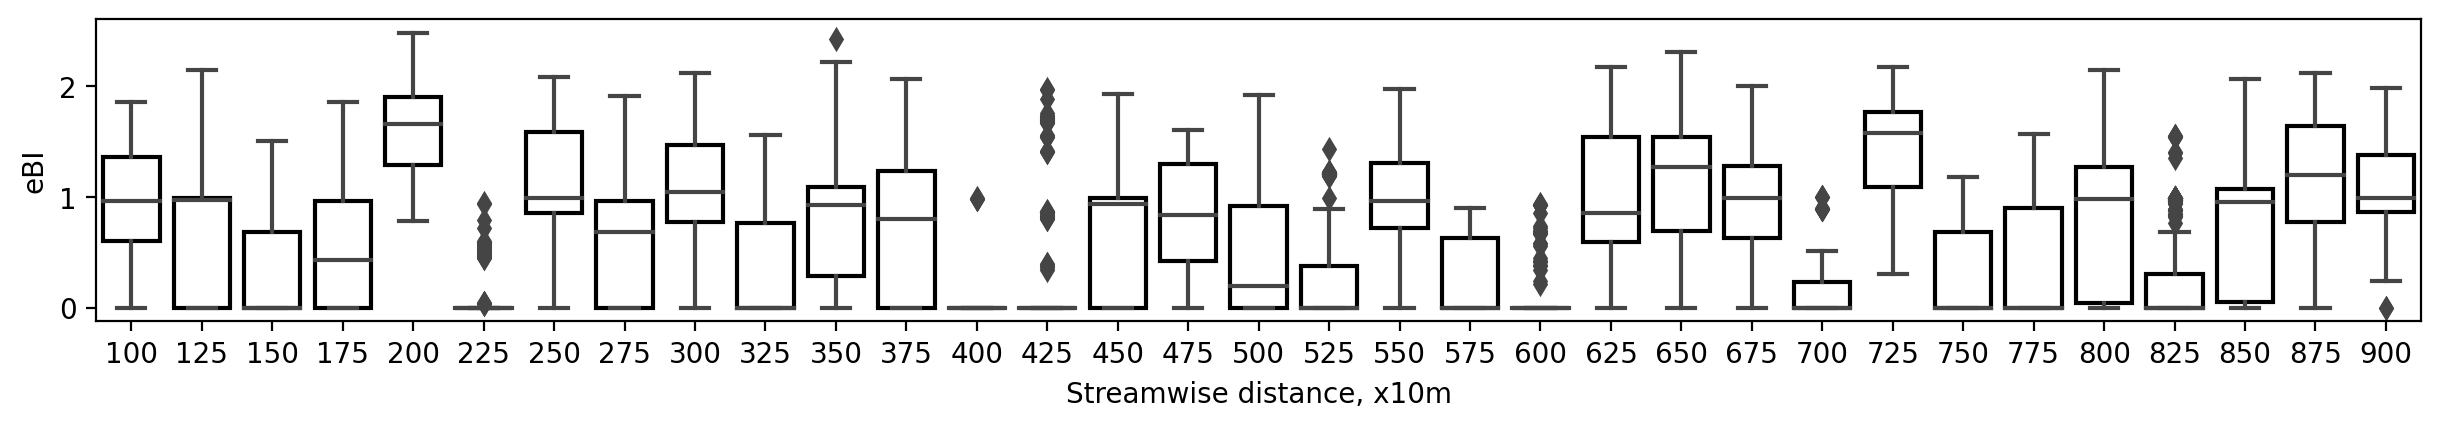

In [218]:
plt.figure(figsize = (15,2), dpi = 200)
PROPS = {'boxprops':{'facecolor':'none', 'edgecolor':'black'},}
sns.boxplot(data = ebidf, **PROPS)

plt.ylabel('eBI')
plt.xlabel('Streamwise distance, x10m')

plt.savefig('/Users/safiya/Desktop/BarManuscript_2022-local/figs/python-results/eBI.png', dpi = 300, transparent = True)

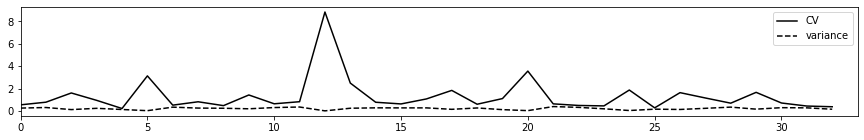

In [221]:
plt.figure(figsize = (15, 2))
plt.plot(stats.variation(ebi2d, axis = 0), 'k', label = 'CV')
plt.plot(np.var(ebi2d, axis = 0), 'k--', label = 'variance')
plt.legend()
plt.xlim(0, 33)
plt.savefig('/Users/safiya/Desktop/BarManuscript_2022-local/figs/python-results/eBI_CVVar.png', dpi = 300, transparent = True)

In [ ]:
#print(len(posnew_nb))
#l_edges = np.empty([1,]) #left edge distance measure of the wheeler fill
l_idx = np.empty([1,]) #index value of left edge
#r_edges = np.empty([1,]) #right edge of the wheeler fill
r_idx = np.empty([1,]) #index value of right edge
surf_age = np.empty([1,]) #age of each deposit for the wheeler diagram
for i in range (0, len(delta)):
    #if ~np.isnan(deposurf[i, 0]):
    #   rectangles[i, 0] = ages[i, 0] #if the left edge of the stratigraphy is a depositional surface

    for xpos in range (0, len(posnew_nb)-1):
        l_edge = np.all((np.isnan(delta[i, xpos]) and ~np.isnan(delta[i, xpos+1])))
        r_edge = np.all((~np.isnan(delta[i, xpos]) and np.isnan(delta[i, xpos+1])))
        #print(xpos, 'L', l_edge)
        #print(xpos, 'R', r_edge)
        if l_edge == True:
            #l_edges = np.append(l_edges, [posnew_nb[xpos+1]], axis = 0)
            l_idx = np.append(l_idx, [xpos], axis = 0)
            #print(posnew_nb[xpos+1], 'potato')
            surf_age = np.append(surf_age, [i], axis = 0)
        if r_edge == True:
            #print(xpos, 'tomato')
            #r_edges = np.append(r_edges, [posnew_nb[xpos-1]], axis = 0)
            r_idx = np.append(r_idx, [xpos], axis = 0)
            
#surf_age = np.append(surf_age, [i+1], axis = 0)
#print('L', l_edges)
#print('R',r_edges)
#print(dep_age)